In [ ]:
!pip install norse torch torchvision matplotlib

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import norse.torch as norse
import matplotlib.pyplot as plt

In [ ]:
# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
mnist_train = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=1000, shuffle=False)

In [ ]:
# Define the ANN model
class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(784, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 784)  # Flatten the images
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [ ]:
# Define the SNN model
class SNN(nn.Module):
    def __init__(self):
        super(SNN, self).__init__()
        self.fc1 = nn.Linear(784, 128)
        self.lif1 = norse.LIFCell()  # LIF neuron layer
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 784)  # Flatten the images
        x = self.lif1(self.fc1(x))  # Linear layer followed by LIF neuron layer
        x = self.fc2(x[0])  # Only use the voltage component for the next layer
        return x

In [ ]:
# Function for training and evaluation
def train_and_evaluate(model, train_loader, test_loader, device, epochs=3):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    # Training loop
    for epoch in range(epochs):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

    # Evaluation loop
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    accuracy = 100 * correct / total
    return accuracy


In [ ]:
# Main
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Train and evaluate ANN
ann_model = ANN()
ann_accuracy = train_and_evaluate(ann_model, train_loader, test_loader, device)


In [ ]:
# Train and evaluate SNN
snn_model = SNN()
snn_accuracy = train_and_evaluate(snn_model, train_loader, test_loader, device)

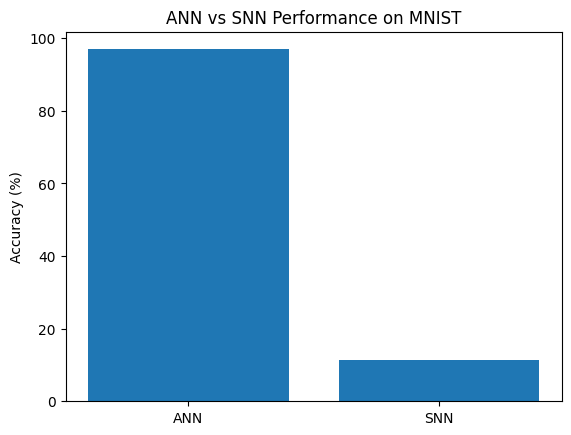

In [ ]:
# Plotting
plt.bar(['ANN', 'SNN'], [ann_accuracy, snn_accuracy])
plt.ylabel('Accuracy (%)')
plt.title('ANN vs SNN Performance on MNIST')
plt.show()